In [1]:
%reset -f
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from aux import Generic
from lin_fit import fit_h, fit_h_train_test
from disp import set_font_size

DT = 0.1

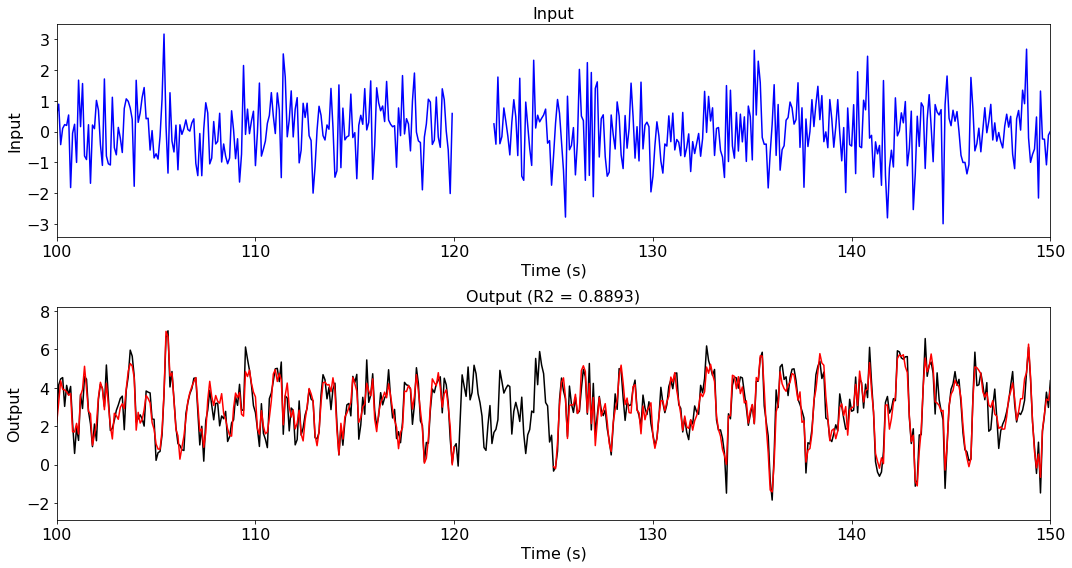

In [2]:
def test_fit_h():
    
    np.random.seed(0)

    # filter
    wdw = (-3, 0)
    t_h = np.arange(*wdw, DT)
    h = np.exp(t_h/1) * np.cos(4 * t_h)
    
    # mock data
    t = np.arange(0, 300, DT)
    x = np.random.normal(0, 1, t.shape)
    
    # convolve x with filter h
    y = np.convolve(x, np.concatenate([h, np.zeros(h.shape)])[::-1], mode='same') \
        + np.random.normal(0, .5, t.shape) + 3
        
    # throw in some nans
    x[int(120/DT):int(122/DT)] = np.nan
    
    # set up params for filter-fitting function
    xs = {'x': x}
    wdws_d = {'x': (int(round(wdw[0]/DT)), int(round(wdw[1]/DT)))}
    
    order = ['x']
    method = 'built-in'
    params = {'model': LinearRegression}
    
    # fit filters and get predictions/r2
    hs, icpt, y_hat, r2 = fit_h(xs, y, wdws_d, order, method, params)
    
    h_hat = hs['x']
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 8), tight_layout=True)
    
    axs[0].plot(t, x, color='b')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Input')
    axs[0].set_title('Input')
    
    axs[1].plot(t, y, color='k')
    axs[1].plot(t, y_hat, color='r')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Output')
    axs[1].set_title('Output (R2 = {0:.4f})'.format(r2))
    
    for ax in axs:
        ax.set_xlim(100, 150)
        set_font_size(ax, 16)
    
test_fit_h()

# Causality analysis
Demonstration of how switching input statistics + nonlinearity can enable reconstructed filter to have significant "acausal" components, even when actual relationship is purely causal.

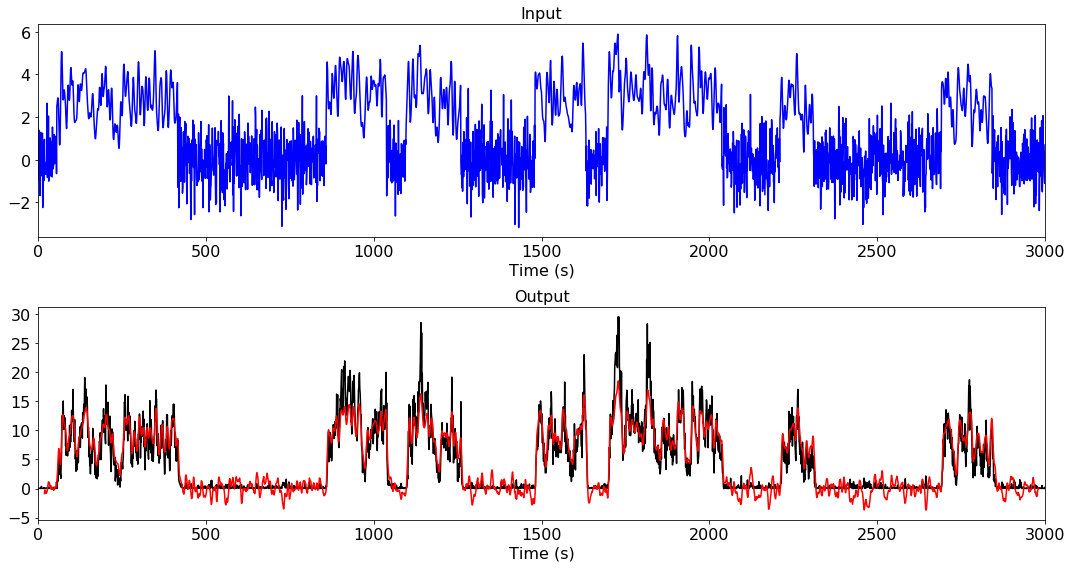

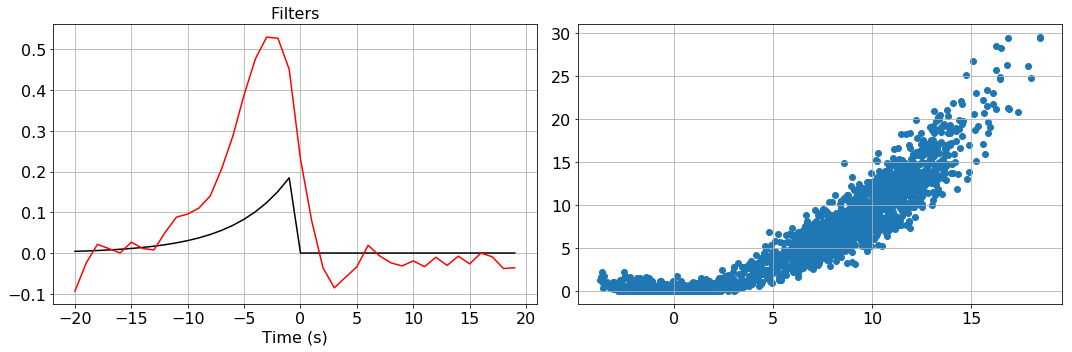

In [3]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d as smooth
from sklearn import linear_model

from disp import set_font_size
from lin_fit import fit_h


SMOOTH_X_0 = 0
SMOOTH_X_1 = 2
STD_X = 1
N_SWITCH = 20
T_SWITCH = 100
STD_ETA = .3  #.5  #.5
SMOOTH_ETA = 0 # 5
T_H = 20
TAU_H = 5
MAG_H = 1
T = 3000
ALPHA = .5

#np.random.seed(0)

# make signals
## input
x_0 = np.random.randn(T)

if SMOOTH_X_0:
    x_0 = smooth(x_0, SMOOTH_X_0)
    
x_0 *= STD_X/x_0.std()

## input
x_1 = np.random.randn(T)

if SMOOTH_X_1:
    x_1 = smooth(x_1, SMOOTH_X_1)
    
x_1 *= STD_X/x_1.std()
x_1 += 3

x = x_0.copy()

for t_start in np.random.permutation(T)[:N_SWITCH]:
    t_start_ = max(t_start, 0)
    t_end_ = t_start_ + T_SWITCH
    
    x[t_start_:t_end_] = x_1[t_start_:t_end_]

## causal filter
t_h = np.arange(-T_H, T_H)
h = np.exp(t_h/TAU_H) # * np.cos(4 * t_h)
h[t_h > -1] = 0
h *= MAG_H / np.sum(h)

## output noise
eta = np.random.randn(T)
if SMOOTH_ETA:
    eta = smooth(eta, SMOOTH_ETA)

eta *= STD_ETA/eta.std()

## output
y = np.zeros(T)
for step in range(T_H, len(x)-T_H):
    x_ = x[step-T_H:step+T_H]
    y[step] = x_.dot(h)
    
y += eta
y **= 2

# recover filters
xs = {'x': x}
wdws_d = {'x': (-T_H, T_H)}
order = ['x']
method = 'built-in'
params = {'model': linear_model.LinearRegression}

hs, icpt, y_hat, r2 = fit_h(xs, y, wdws_d, order, method, params)

fig, axs = plt.subplots(2, 1, figsize=(15, 8), tight_layout=True)

axs[0].plot(x, color='b')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('Input')

axs[1].plot(y, color='k')
axs[1].plot(y_hat, color='r')
axs[1].set_xlabel('Time (s)')
axs[1].set_title('Output')

for ax in axs:
    set_font_size(ax, 16)
    ax.set_xlim(0, T)
    
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)
axs[0].plot(t_h, h, color='k')
axs[0].plot(t_h, hs['x'], color='r')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('Filters')

axs[1].scatter(y_hat, y)

for ax in axs:
    ax.grid()
    set_font_size(ax, 16)

# DEPCRECATED
# <###############################################################>

In [ ]:
raise Exception

def test_fit_filter(t_lim, method, params, C):
    
    for test_ctr in range(2):
        
        np.random.seed(0)

        # mock data
        t = np.arange(0, 300, C.DT)
        x = np.random.normal(0, 1, t.shape)

        if test_ctr == 0:
            
            wdw = (-3, 0)
            t_h = np.arange(*wdw, C.DT)
            h = np.exp(t_h/1) * np.cos(4 * t_h)
            h /= np.linalg.norm(h)

            y = np.convolve(x, np.concatenate([h, np.zeros(h.shape)])[::-1], mode='same') \
                + np.random.normal(0, .5, t.shape)
                
        elif test_ctr == 1:
    
            wdw = (-1.5, 1.5)
            t_h = np.arange(*wdw, C.DT)
            h = np.exp(-np.abs(t_h)/1) * np.sin(4 * t_h)
            h /= np.linalg.norm(h)

            y = np.convolve(x, h[::-1], mode='same') \
                + np.random.normal(0, .5, t.shape)

        # mock data loader
        dl = Generic(t=t, x=x, y=y)

        # mock trial
        trial = Generic(name='test_trial', dl=dl)

        # fit function
        rslt = fit_h_train_test(
            trial, 'x', 'y', wdw, 16, 4, method=method, params=params, C=C)

        # plot true and found filters
        gs = gridspec.GridSpec(2, 4)

        fig = plt.figure(figsize=(16, 6), tight_layout=True)
        ax_0 = fig.add_subplot(gs[0, :3])
        ax_1 = fig.add_subplot(gs[1, :3], sharex=ax_0)
        ax_2 = fig.add_subplot(gs[:, 3])

        # plot x, y, y_hat_train, y_hat_test
        ax_0.plot(t, x, color='k', alpha=0.3)
        ax_0.plot(t, y, color='b')

        ax_0.set_ylabel('x, y')
        ax_0.set_title('{0}: R^2 train = {1:.2f}, R^2 test = {2:.2f}'.format(
            rslt.trial_name, rslt.r2_train, rslt.r2_test))

        ax_0.legend(['x', 'y'], ncol=2)

        ax_1.plot(t, x, color='k', alpha=0.3)
        ax_1.plot(t, y, color='b')
        ax_1.plot(t, rslt.y_hat_train, color='r')
        ax_1.plot(t, rslt.y_hat_test, color='g')

        ax_1.set_xlim(*t_lim)

        ax_1.set_xlabel('time (s)')
        ax_1.set_ylabel('x, y, y_hat')
        ax_1.legend(['x', 'y', 'y_hat_train', 'y_hat_test'], ncol=4)

        # plot filters
        ax_2.plot(t_h, h, color='b')
        ax_2.plot(t_h, rslt.h, color='g')

        ax_2.grid()

        ax_2.set_xlabel('t rel. to prediction (s)')
        ax_2.set_ylabel('h')

        ax_2.legend(['true', 'inferred'])

        for ax in [ax_0, ax_1, ax_2]:
            set_font_size(ax, 16)
        
test_fit_filter([100, 130], 'built-in', {'model': LinearRegression}, C)

Test passed if 2nd and 4th row show both red and green following blue line, and if true and inferred filters align for both figures.